## Исследование данных

Мы изучали во многом отдельные темы, которые демонстрируют отдельные темы, однако смысл в том, чтобы применять это в реально анализе данных или полноценных проектов. Для этого важно выстраивать логику исследования и представлять, как это все выглядит в целом.


Можно выделить сделующие этапы:

1. Формулирование исследовательских целей и вопросов
2. Сбор данных (краулеры, API, структура БД)
3. Предобработка данных (морфологический парсинг)
4. Разведочный анализ, корректировка или дополнение вопросов (описательная статистика и т.д.)
5. Анализ данных (подсчеты)
6. Визуализация результатов (графики)
7. Построение выводов 
8. Презентация результатов (оформление тетрадки или презентации)
9. Сохранение кода и данных (бэкап БД, сохранение кода на гитхабе)


https://drive.google.com/drive/folders/16vL2bk0PaLKk2s4ztv8pmIl6vZdddTdq?usp=sharing

In [240]:
from wordcloud import WordCloud
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymorphy2 import MorphAnalyzer
from nltk.tokenize import wordpunct_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import numpy as np

%matplotlib inline

morph = MorphAnalyzer()

In [2]:
data = pd.read_csv("vk_data.csv")

In [6]:
data.drop(["last_name"], axis=1).head()

,id,from_id,post_id,owner_id,date,text,likes,first_name,is_closed,sex,...,university,university_name,faculty,faculty_name,graduation,home_town,education_form,education_status,deactivated,birth_year
0,5027823,323882200.0,5027806.0,-76982440.0,1618990528,Зачем нужен Антон Долин обсудили?,15,Anya,False,1,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,5027858,146100791.0,5027806.0,-76982440.0,1618990863,Пустобрех,1,Valya,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5033062,146100791.0,5033056.0,-76982440.0,1619082366,NaN,0,Valya,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5033075,146100791.0,5032970.0,-76982440.0,1619082647,Что за неведомы зверушки?,0,Valya,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5032935,146100791.0,5032889.0,-76982440.0,1619080048,Что здесь недоступно ддя понимания? Организаци...,4,Valya,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разведочный анализ данных

Можно построить разные графики того, как распределены те или иные показатели. 

Например, найти тех, кто указывает нереалистичный год рождения.

Text(0, 0.5, 'Кол-во людей')

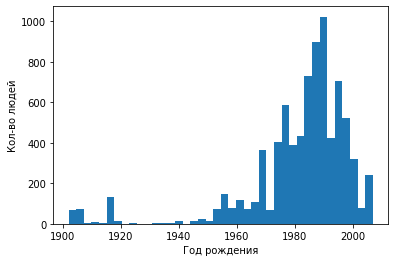

In [33]:
data["birth_year"].plot(kind="hist", bins=40)
plt.xlabel("Год рождения")
plt.ylabel("Кол-во людей")

Можно построить график количества лайков. Так как мало лайков получают очень много постов, можно сделать логарифмическую шкалу.

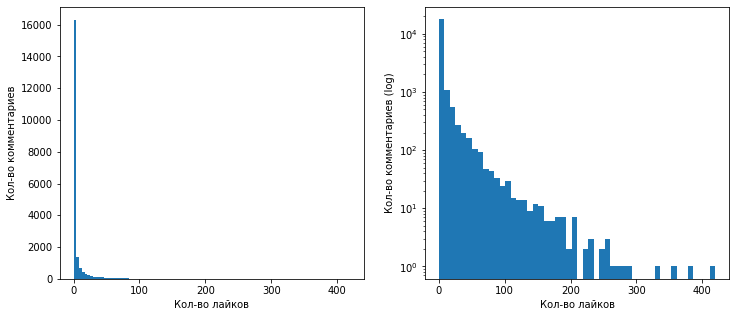

In [53]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)

data["likes"].plot(kind="hist", bins=100, ax=ax1)
plt.xlabel("Кол-во лайков")
plt.ylabel("Кол-во комментариев")
# plt.show()

ax2 = plt.subplot(1, 2, 2)

data["likes"].plot(kind="hist", bins=50, logy=True, ax=ax2)
plt.xlabel("Кол-во лайков")
plt.ylabel("Кол-во комментариев (log)")

plt.show()

In [55]:
users = data.drop_duplicates(subset=["from_id"])

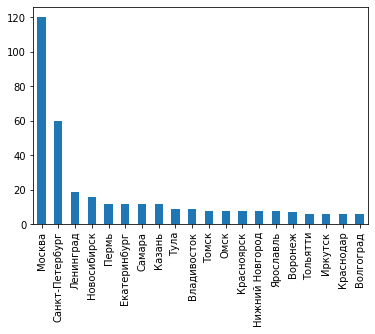

In [62]:
users["home_town"].value_counts()[:20].plot(kind="bar");

Гендерное распределение:

2 - мужчины
1 - женщины
0 - не указано

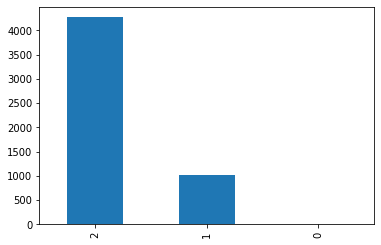

In [63]:
users["sex"].value_counts().plot(kind="bar");

Можно увидеть, что женщины немного моложе мужчин, рапределение сдвинуто вправо относительно пика распределения года рождения у мужчин.

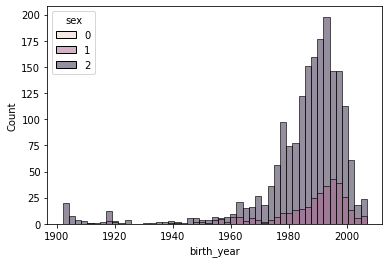

In [65]:
sns.histplot(x="birth_year", hue="sex", data=users);

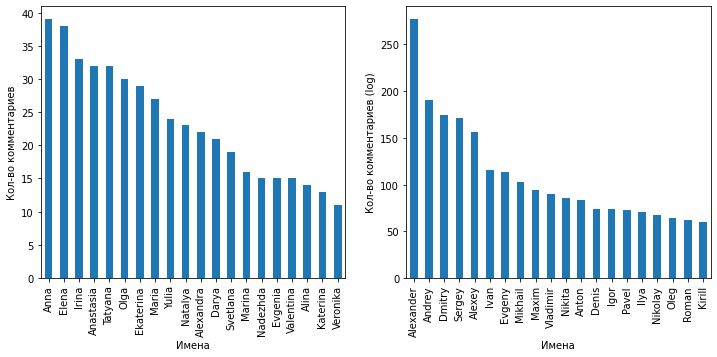

In [85]:
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)

users[users["sex"] == 1]["first_name"].value_counts()[:20].plot(kind="bar");
plt.xlabel("Имена")
plt.ylabel("Кол-во комментариев")
# plt.show()

ax2 = plt.subplot(1, 2, 2)

users[users["sex"] == 2]["first_name"].value_counts()[:20].plot(kind="bar");
plt.xlabel("Имена")
plt.ylabel("Кол-во комментариев (log)")

plt.show()

### Исследовательские вопросы

Можно много чего использовать, но ограничимся простыми вопросами:

1. Какие самые популярные эмодзи?
2. Как часто пользователи делают ошибки из ряда жи-ши, ча-ща, чу-щу?

### Предобработка данных

In [68]:
morph.parse("слово")[0].normal_form

'слово'

In [74]:
def parse_text(x):
    if type(x) == str:
        result = [morph.parse(i)[0].normal_form for i in wordpunct_tokenize(x)]
        return " ".join(result)
    return x

In [75]:
data["lemmatized"] = data["text"].apply(parse_text)

In [89]:
data["lemmatized"] = data["lemmatized"].fillna("")

### Анализ

В эту часть можно включить и часть разведочного анализа (в зависимости от вопросов)

#### Эмодзи

In [126]:
def extract_emojis(s):
    if type(s) != str:
        return tuple()
    return tuple([i.get("emoji") for i in emoji.emoji_lis(s)])

In [114]:
extract_emojis('😃')

['😃']

In [128]:
data["emoji"] = data["text"].apply(extract_emojis)
data["emoji_cnt"] = data["emoji"].apply(len)

In [129]:
data[["emoji", "emoji_cnt"]].drop_duplicates()

,emoji,emoji_cnt
0,(),0
352,"(😂, 😂)",2
353,"(😂, 👇🏻)",2
364,"(❗,)",1
368,"(😂, 😂, 😂)",3
...,...,...
20330,"(👏, 👏, 👏, 👏)",4
20371,"(🇰🇵,)",1
20383,"(🌰,)",1
20386,"(😂, 🙈, 🙉, 💀)",4


In [241]:
emojis = []
for i in data["emoji"].values:
    emojis.extend(list(i))
    
freq = Counter(emojis)

In [225]:
! wget https://github.com/amueller/word_cloud/blob/master/examples/fonts/Symbola/Symbola.ttf?raw=true

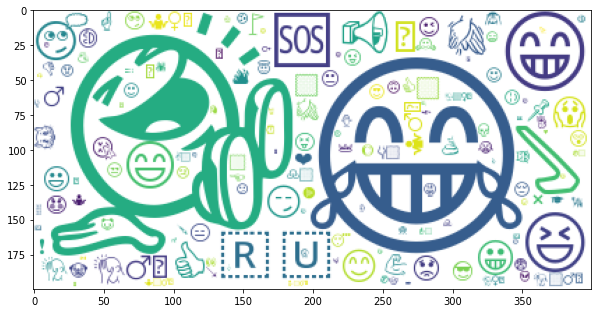

In [246]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(background_color="white", regexp="\S+", font_path="./Symbola.ttf").generate_from_frequencies(freq)
plt.imshow(wordcloud)
plt.show()

#### Ошибки

In [148]:
def find_zhi(x):
    if type(x) != str:
        return tuple()
    result = re.findall("(?:^| )[^ ]*?(?:жы|шы|чя|щя|чю|щю)[^ ]*?(?:$| )", x)
    return tuple(result)

In [149]:
data["zhi"] = data["text"].apply(find_zhi)
data["zhi_cnt"] = data["zhi"].apply(len)

In [257]:
data[data["zhi_cnt"] > 0][["zhi", "birth_year"]]#.drop_duplicates()

,zhi,birth_year
1485,"( зажывём,)",NaN
1782,"( жы,)",NaN
2106,"( жызнь? ,)",NaN
3484,"( жыдов ,)",1991.0
4991,"( режымом ,)",NaN
10300,"( жыдярва ,)",NaN
10315,"( жыдов- ,)",NaN
10368,"( жыдярвяков, ,)",NaN
10373,"( режым ,)",NaN
10374,"( жыдолибегастманов"",)",NaN
